In [71]:
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima.model import ARIMA

Ex1

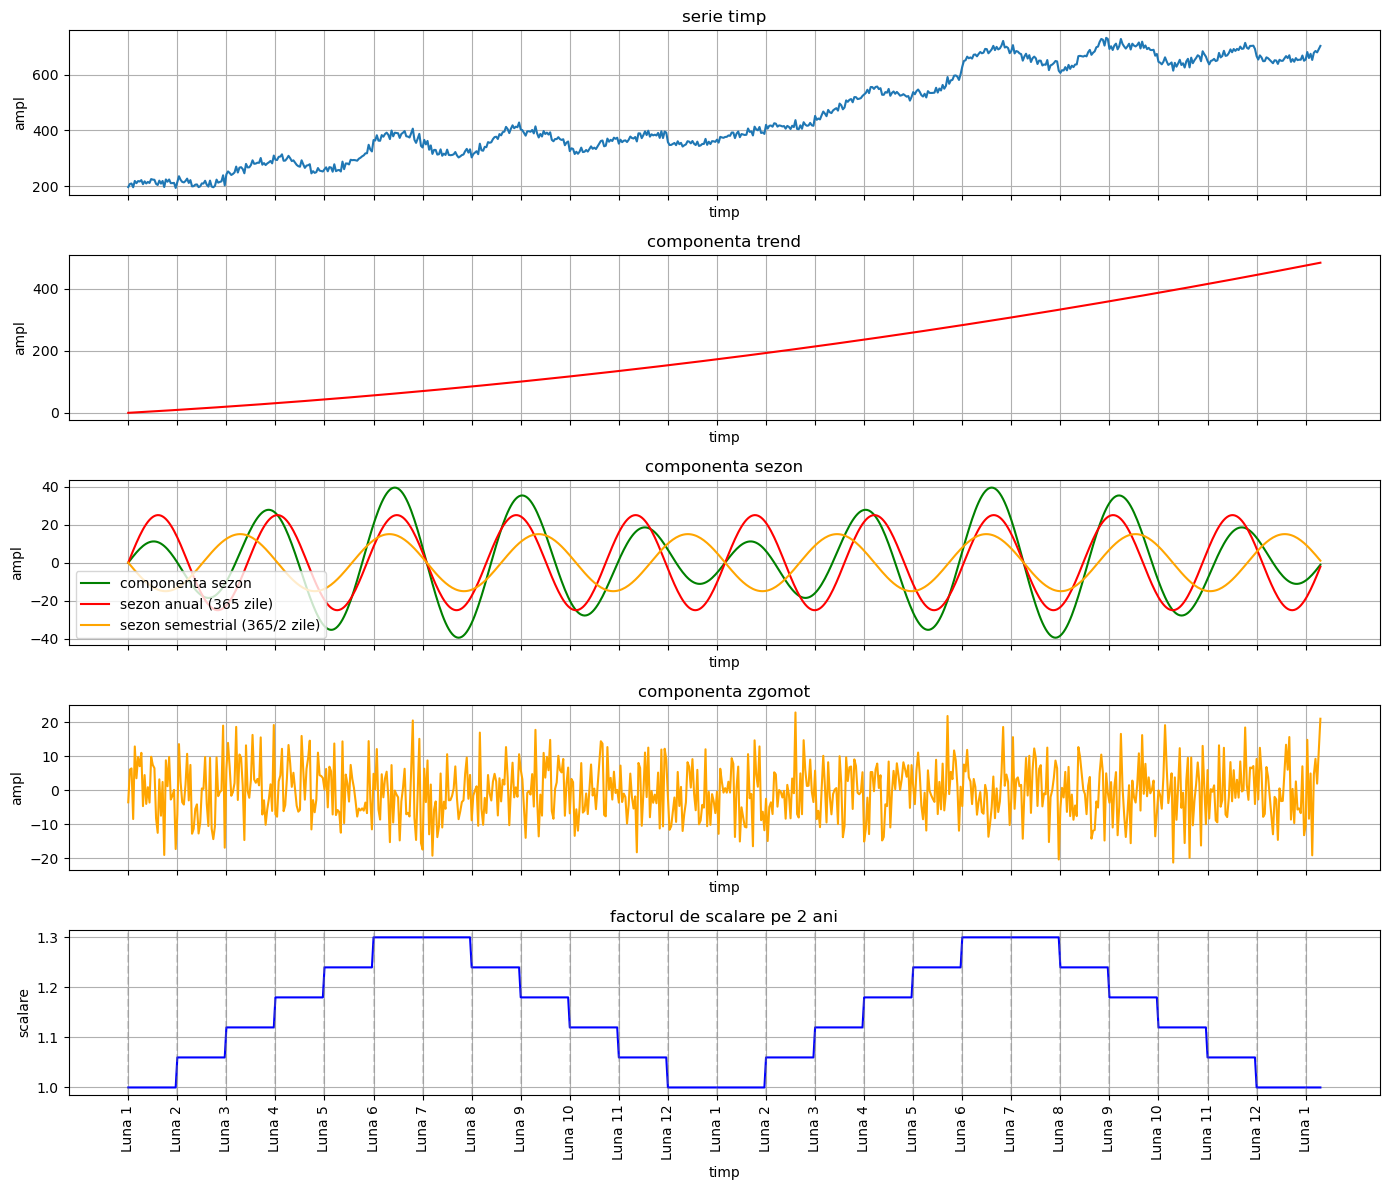

In [37]:
# lab 8
# e stabilit ca sezonul e o functie sezoniera care trebuie sa aiba in componenta ei doua frecvente, iar trend-ul e o ec polinomiala
# i will quote my own repo de unde iau o idee de time series
# https://github.com/andialexandrescu/Seasonal_Sales_Predictor_OracleAI23/blob/main/generare_seasonal_time_series_vanzari.sql
os.makedirs("./lab9_plots/ex1", exist_ok=True)

# interpretez seria de timp a unor vanzari timp de trei ani, fiind indexul fiecarei zile
# vreau vanzarile sa creasca in prima parte a anului, dupa aceea sa scada treptat
# intervalul de timp t pe care voi descrie seria de timp e de 2 ani
N = 365*2
t = np.arange(N)
zile_pe_luna = 30
luna = (t//zile_pe_luna)%12+1
#  if luna < 7
#             then
#                 scalare := 1.0 + (luna-1) * (0.3/5);-- prima jum a anului inseamna o crestere de la 1.0 la 1.3
#             else
#                 scalare := 1.3 - (luna-7) * (0.3/5);-- o scadere de la 1.3 la 1.0
#             end if;
scalare = np.zeros_like(luna, dtype=float)
scalare[luna<7] = 1.0 + (luna[luna<7] - 1) * (0.3/5)
scalare[luna>=7] = 1.3 - (luna[luna>=7] - 7) * (0.3/5)

# factor_sezonier := ampl_sezonier * sin(2*acos(-1)*index_zi/365);-- acos(-1) = pi, codif zilelor dintr-un an, totusi trebuie impartit la nr de zile care completeaza ciclul
#             -- SAU V2: https://skforecast.org/0.10.0/faq/cyclical-features-time-series
#             -- signal_1 = 3 + 4 * sin(index_zi/365*2*acos(-1))
#             -- signal_2 = 3 * sin(index_zi/365*4*acos(-1)+365/2)
#             zgomot := zgomot_std * dbms_random.normal;
    
#             -- additive + multiplicative time series
#             aux_vanzari_zilnice := (nivel_baza + factor_sezonier + zgomot) * scalare;

nivel_baza = 200 # nivel de baza stabilit in proiectul meu anterior pentru date de vanzari care sa nu scada sub acest prag
# nivel_baza number default 200,
factor_trend = 0.0005*t**2+0.3*t

ampl_sezonier_1 = 25 # amplificator sezonier, cat de mult variatia sezoniera poate sa scada/ creasca
ampl_sezonier_2 = 15
frecv_1 = 5
frecv_2 = 2
factor_sezonier_1 = ampl_sezonier_1 * np.sin(2*np.pi*t*frecv_1/365)
factor_sezonier_2 = ampl_sezonier_2 * np.sin(2*np.pi*t*frecv_2/(365/2)+np.pi) # defazaj
factor_sezonier = factor_sezonier_1+factor_sezonier_2

zgomot_std = 8
zgomot = zgomot_std*np.random.randn(N)

serie_timp = (nivel_baza+factor_trend+factor_sezonier+zgomot)*scalare

fig, axs = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

axs[0].plot(t, serie_timp)
axs[0].set_title('serie timp')
axs[0].set_xlabel('timp')
axs[0].set_ylabel('ampl')
axs[0].grid(True)

axs[1].plot(t, factor_trend, color='red')
axs[1].set_title('componenta trend')
axs[1].set_xlabel('timp')
axs[1].set_ylabel('ampl')
axs[1].grid(True)

axs[2].plot(t, factor_sezonier, color='green', label='componenta sezon')
axs[2].plot(t, factor_sezonier_1, color='red', label='sezon anual (365 zile)')
axs[2].plot(t, factor_sezonier_2, color='orange', label='sezon semestrial (365/2 zile)')
axs[2].set_title('componenta sezon')
axs[2].set_xlabel('timp')
axs[2].set_ylabel('ampl')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(t, zgomot, color='orange')
axs[3].set_title('componenta zgomot')
axs[3].set_xlabel('timp')
axs[3].set_ylabel('ampl')
axs[3].grid(True)

axs[4].plot(t, scalare, color='blue', label='factor scalare')
axs[4].set_title('factorul de scalare pe 2 ani')
axs[4].set_xlabel('timp')
axs[4].set_ylabel('scalare')
axs[4].grid(True)

# din lab5
nr_luni = 24
L_tick_luna = [i*zile_pe_luna for i in range(nr_luni+1)]
L_label_luna = [f'Luna {((i)%12)+1}' for i in range(nr_luni+1)]
axs[4].set_xticks(L_tick_luna)
axs[4].set_xticklabels(L_label_luna, rotation=90)
for tick in L_tick_luna:
    axs[4].axvline(x=tick, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f"lab9_plots/ex1/generare_serie_timp.pdf", format="pdf")
plt.show()

Ex2

In [38]:
# simple exponential smoothing - alpha
os.makedirs("./lab9_plots/ex2", exist_ok=True)

alpha_fixat = 0.5

def calculeaza_ses(alpha):
    n = len(serie_timp)
    ses = np.zeros(n)
    ses[0] = serie_timp[0]
    for t in range(1, n):
        ses[t] = alpha*serie_timp[t]+(1-alpha)*ses[t-1]
    return ses

ses_alpha_fixat = calculeaza_ses(alpha_fixat)
print(f"mse pt alpha={alpha_fixat} ses: {np.mean((serie_timp-ses_alpha_fixat)**2):.2f}")

def optimizare_param_ses(alpha):
    ses = calculeaza_ses(alpha[0])
    return np.mean((serie_timp-ses)**2)

L_alpha = np.linspace(0.01, 0.99, 100) # 100 valori uniforme
L_mse = np.zeros(len(L_alpha))

k = 0
for i, alpha in enumerate(L_alpha):
    L_mse[i] = optimizare_param_ses([alpha])
    k += 1
    print(f"\tk={k}: alpha={alpha:.2f} => mse={L_mse[i]:.2f}")

min_index = np.argmin(L_mse)
alpha_optim = L_alpha[min_index]
mse_optim = L_mse[min_index]
print(f"\nalpha optim ses: {alpha_optim:.2f}")
print(f"mse pt alpha optim ses: {mse_optim:.2f}")

mse pt alpha=0.5 ses: 37.93
	k=1: alpha=0.01 => mse=5926.55
	k=2: alpha=0.02 => mse=2391.75
	k=3: alpha=0.03 => mse=1479.57
	k=4: alpha=0.04 => mse=1081.88
	k=5: alpha=0.05 => mse=856.37
	k=6: alpha=0.06 => mse=706.82
	k=7: alpha=0.07 => mse=597.99
	k=8: alpha=0.08 => mse=514.37
	k=9: alpha=0.09 => mse=447.96
	k=10: alpha=0.10 => mse=394.12
	k=11: alpha=0.11 => mse=349.79
	k=12: alpha=0.12 => mse=312.87
	k=13: alpha=0.13 => mse=281.82
	k=14: alpha=0.14 => mse=255.47
	k=15: alpha=0.15 => mse=232.93
	k=16: alpha=0.16 => mse=213.51
	k=17: alpha=0.17 => mse=196.65
	k=18: alpha=0.18 => mse=181.91
	k=19: alpha=0.19 => mse=168.96
	k=20: alpha=0.20 => mse=157.49
	k=21: alpha=0.21 => mse=147.30
	k=22: alpha=0.22 => mse=138.17
	k=23: alpha=0.23 => mse=129.96
	k=24: alpha=0.24 => mse=122.55
	k=25: alpha=0.25 => mse=115.81
	k=26: alpha=0.26 => mse=109.67
	k=27: alpha=0.27 => mse=104.04
	k=28: alpha=0.28 => mse=98.87
	k=29: alpha=0.29 => mse=94.09
	k=30: alpha=0.30 => mse=89.67
	k=31: alpha=0.31 =>

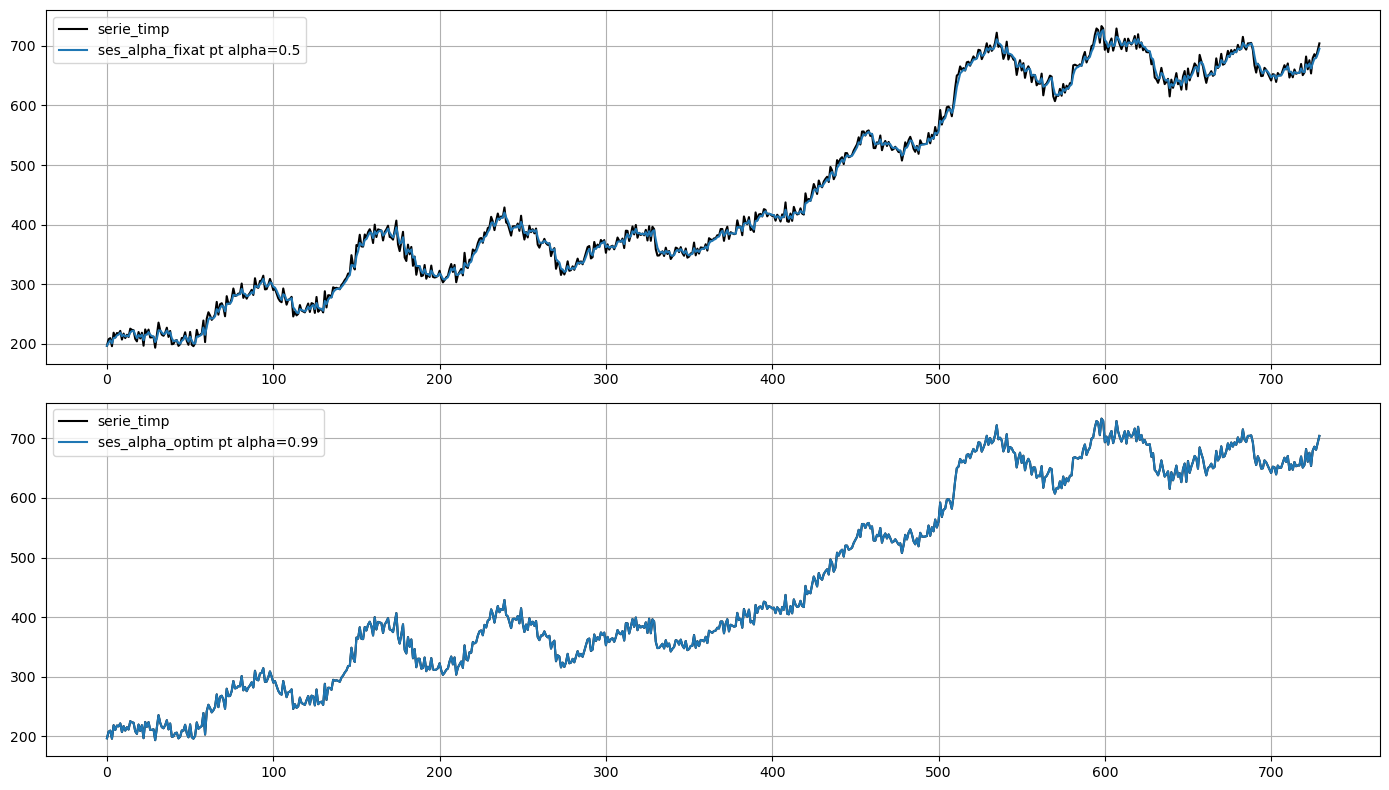

In [39]:
# ses cu alpha optim si plot comparativ
ses_alpha_optim = calculeaza_ses(alpha_optim)

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

axs[0].plot(serie_timp, label='serie_timp', color='black')
axs[0].plot(ses_alpha_fixat, label=f'ses_alpha_fixat pt alpha={alpha_fixat}')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(serie_timp, label='serie_timp', color='black')
axs[1].plot(ses_alpha_optim, label=f'ses_alpha_optim pt alpha={alpha_optim}')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.savefig(f"lab9_plots/ex2/simple_exponential_smoothing.pdf", format="pdf")
plt.show()

In [40]:
# double exponential smoothing - alpha si beta
alpha_fixat, beta_fixat = 0.5, 0.1

def calculeaza_des(alpha, beta):
    n = len(serie_timp)
    des = np.zeros(n)
    des_trend = np.zeros(n)
    des[0] = serie_timp[0]
    des_trend[0] = serie_timp[1]-serie_timp[0]
    for t in range(1, n):
        prev_level = des[t-1]
        prev_trend = des_trend[t-1]
        des[t] = alpha*serie_timp[t]+(1-alpha)*(prev_level+prev_trend)
        des_trend[t] = beta*(des[t]-prev_level)+(1-beta)*prev_trend
    des_forecast = des+des_trend
    return des_forecast

des_alpha_beta_fixat = calculeaza_des(alpha_fixat, beta_fixat)
print(f"mse pt alpha={alpha_fixat}, beta={beta_fixat} des: {np.mean((serie_timp-des_alpha_beta_fixat)**2):.2f}")

def optimizare_param_des(params):
    alpha, beta = params
    des = calculeaza_des(alpha, beta)
    return np.mean((serie_timp-des)**2)

L_alpha = np.linspace(0.01, 0.99, 100)
L_beta = np.linspace(0.01, 0.99, 100)
L_mse = np.zeros((len(L_alpha), len(L_beta)))

k = 0
for i, alpha in enumerate(L_alpha):
    for j, beta in enumerate(L_beta):
        L_mse[i, j] = optimizare_param_des([alpha, beta])
        k += 1
        print(f"\tk={k}: alpha={alpha:.2f}, beta={beta:.2f} => mse={L_mse[i, j]:.2f}")

min_index = np.unravel_index(np.argmin(L_mse), L_mse.shape)
alpha_optim = L_alpha[min_index[0]]
beta_optim = L_beta[min_index[1]]
mse_optim = L_mse[min_index]
print(f"\nalpha optim des: {alpha_optim:.2f}")
print(f"beta optim des: {beta_optim:.2f}")
print(f"mse pt alpha optim des: {mse_optim:.2f}")

mse pt alpha=0.5, beta=0.1 des: 41.19
	k=1: alpha=0.01, beta=0.01 => mse=78640.89
	k=2: alpha=0.01, beta=0.02 => mse=38766.85
	k=3: alpha=0.01, beta=0.03 => mse=24017.31
	k=4: alpha=0.01, beta=0.04 => mse=18625.70
	k=5: alpha=0.01, beta=0.05 => mse=16240.06
	k=6: alpha=0.01, beta=0.06 => mse=14455.88
	k=7: alpha=0.01, beta=0.07 => mse=12692.56
	k=8: alpha=0.01, beta=0.08 => mse=11100.10
	k=9: alpha=0.01, beta=0.09 => mse=9854.27
	k=10: alpha=0.01, beta=0.10 => mse=8938.99
	k=11: alpha=0.01, beta=0.11 => mse=8253.34
	k=12: alpha=0.01, beta=0.12 => mse=7696.94
	k=13: alpha=0.01, beta=0.13 => mse=7221.08
	k=14: alpha=0.01, beta=0.14 => mse=6815.25
	k=15: alpha=0.01, beta=0.15 => mse=6478.52
	k=16: alpha=0.01, beta=0.16 => mse=6210.57
	k=17: alpha=0.01, beta=0.17 => mse=6004.76
	k=18: alpha=0.01, beta=0.18 => mse=5845.05
	k=19: alpha=0.01, beta=0.19 => mse=5712.34
	k=20: alpha=0.01, beta=0.20 => mse=5590.25
	k=21: alpha=0.01, beta=0.21 => mse=5466.19
	k=22: alpha=0.01, beta=0.22 => mse=533

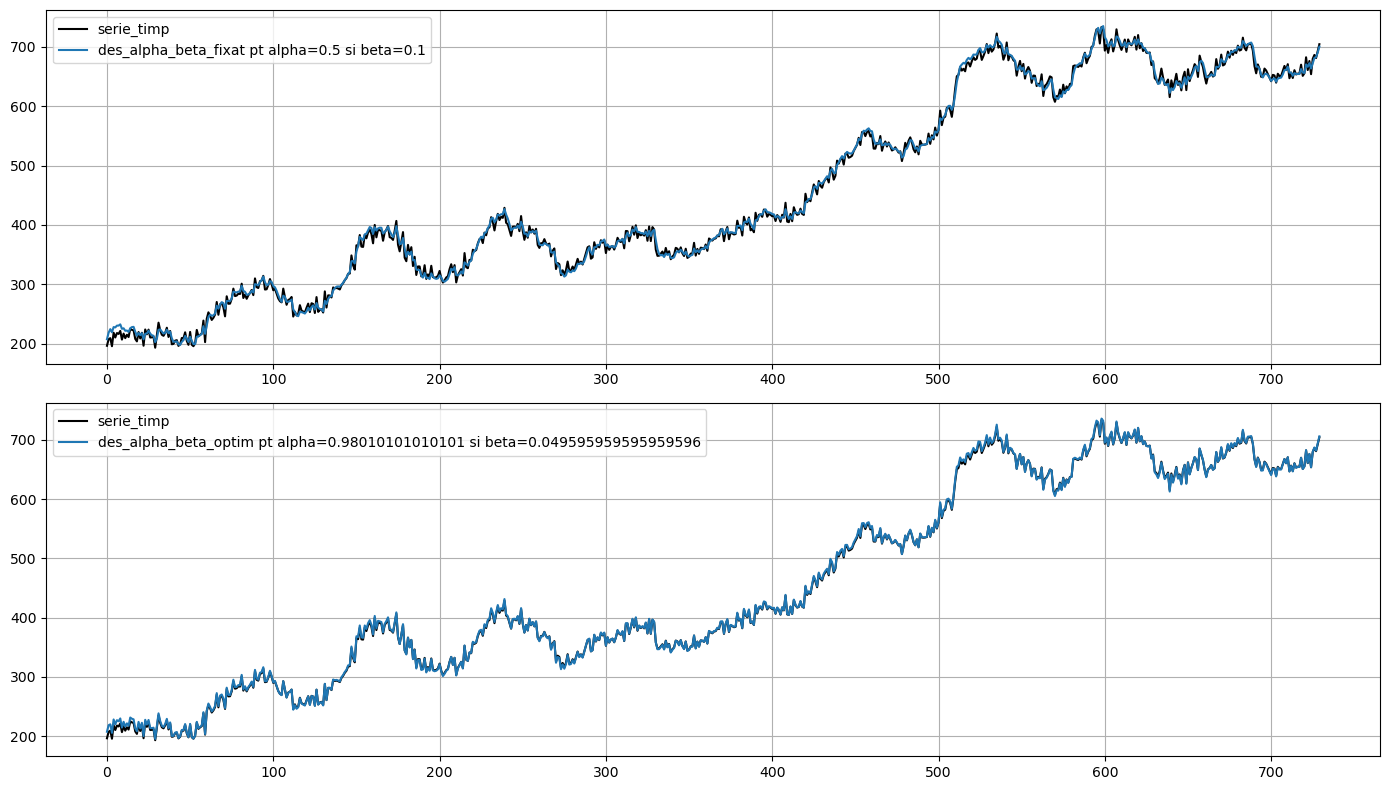

In [41]:
des_alpha_beta_optim = calculeaza_des(alpha_optim, beta_optim)

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

axs[0].plot(serie_timp, label='serie_timp', color='black')
axs[0].plot(des_alpha_beta_fixat, label=f'des_alpha_beta_fixat pt alpha={alpha_fixat} si beta={beta_fixat}')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(serie_timp, label='serie_timp', color='black')
axs[1].plot(des_alpha_beta_optim, label=f'des_alpha_beta_optim pt alpha={alpha_optim} si beta={beta_optim}')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.savefig(f"lab9_plots/ex2/double_exponential_smoothing.pdf", format="pdf")
plt.show()

In [42]:
# triple exponential smoothing - alpha, beta si gamma
alpha_fixat, beta_fixat, gamma_fixat = 0.3, 0.1, 0.3

def calculeaza_tes(alpha, beta, gamma):
    n = len(serie_timp)
    perioada = 30 # lunar

    tes = np.zeros(n)
    tes_trend = np.zeros(n)
    tes_sezon = np.zeros(n)
    tes[:perioada] = serie_timp[:perioada].mean() # media primele 30 de zile
    tes_trend[:perioada] = np.mean(np.diff(serie_timp[:perioada+1])) # media diferentelor intre elem consecutive pt a observa cresterea mediei zilnice, atentie perioada+1
    tes_sezon[:perioada] = serie_timp[:perioada]-tes[:perioada] # dif dintre seria de timp si media primelor 30 de zile

    for t in range(perioada, n):
        i = t%perioada
        prev_level = tes[t-1]
        prev_trend = tes_trend[t-1]
        prev_sezon = tes_sezon[i-1]
        
        tes[t] = (alpha*(serie_timp[t]-prev_sezon)+(1-alpha)*(prev_level+prev_trend))
        tes_trend[t] = (beta*(tes[t]-prev_level)+(1-beta)*prev_trend)
        tes_sezon[i] = (gamma*(serie_timp[t]-tes[t])+(1-gamma)*prev_sezon)
    tes_forecast = tes+tes_trend+tes_sezon
    return tes_forecast

tes_alpha_beta_gamma_fixat = calculeaza_tes(alpha_fixat, beta_fixat, gamma_fixat)
print(f"mse pt alpha={alpha_fixat}, beta={beta_fixat}, gamma={gamma_fixat} tes: "f"{np.mean((serie_timp-tes_alpha_beta_gamma_fixat)**2):.2f}")

def optimizare_param_tes(params):
    alpha, beta, gamma = params
    tes = calculeaza_tes(alpha, beta, gamma)
    return np.mean((serie_timp-tes)**2)

L_alpha = np.linspace(0.01, 0.99, 30)
L_beta = np.linspace(0.01, 0.99, 30)
L_gamma = np.linspace(0.01, 0.99, 30)
L_mse = np.zeros((len(L_alpha), len(L_beta), len(L_gamma)))

k = 0
for i, alpha in enumerate(L_alpha):
    for j, beta in enumerate(L_beta):
        for m, gamma in enumerate(L_gamma):
            L_mse[i, j, m] = optimizare_param_tes([alpha, beta, gamma])
            k += 1
            print(f"\tk={k}: alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f} => mse={L_mse[i, j, m]:.2f}")

min_index = np.unravel_index(np.argmin(L_mse), L_mse.shape)
alpha_optim = L_alpha[min_index[0]]
beta_optim = L_beta[min_index[1]]
gamma_optim = L_gamma[min_index[2]]
mse_optim = L_mse[min_index]
print(f"\nalpha optim des: {alpha_optim:.2f}")
print(f"beta optim des: {beta_optim:.2f}")
print(f"gamma optim des: {gamma_optim:.2f}")
print(f"mse pt alpha optim des: {mse_optim:.2f}")

mse pt alpha=0.3, beta=0.1, gamma=0.3 tes: 195.61
	k=1: alpha=0.01, beta=0.01, gamma=0.01 => mse=2916.46
	k=2: alpha=0.01, beta=0.01, gamma=0.04 => mse=3026.88
	k=3: alpha=0.01, beta=0.01, gamma=0.08 => mse=3000.31
	k=4: alpha=0.01, beta=0.01, gamma=0.11 => mse=2975.72
	k=5: alpha=0.01, beta=0.01, gamma=0.15 => mse=2980.44
	k=6: alpha=0.01, beta=0.01, gamma=0.18 => mse=3009.76
	k=7: alpha=0.01, beta=0.01, gamma=0.21 => mse=3055.03
	k=8: alpha=0.01, beta=0.01, gamma=0.25 => mse=3109.51
	k=9: alpha=0.01, beta=0.01, gamma=0.28 => mse=3168.72
	k=10: alpha=0.01, beta=0.01, gamma=0.31 => mse=3229.80
	k=11: alpha=0.01, beta=0.01, gamma=0.35 => mse=3290.99
	k=12: alpha=0.01, beta=0.01, gamma=0.38 => mse=3351.21
	k=13: alpha=0.01, beta=0.01, gamma=0.42 => mse=3409.84
	k=14: alpha=0.01, beta=0.01, gamma=0.45 => mse=3466.49
	k=15: alpha=0.01, beta=0.01, gamma=0.48 => mse=3520.98
	k=16: alpha=0.01, beta=0.01, gamma=0.52 => mse=3573.22
	k=17: alpha=0.01, beta=0.01, gamma=0.55 => mse=3623.21
	k=18: 

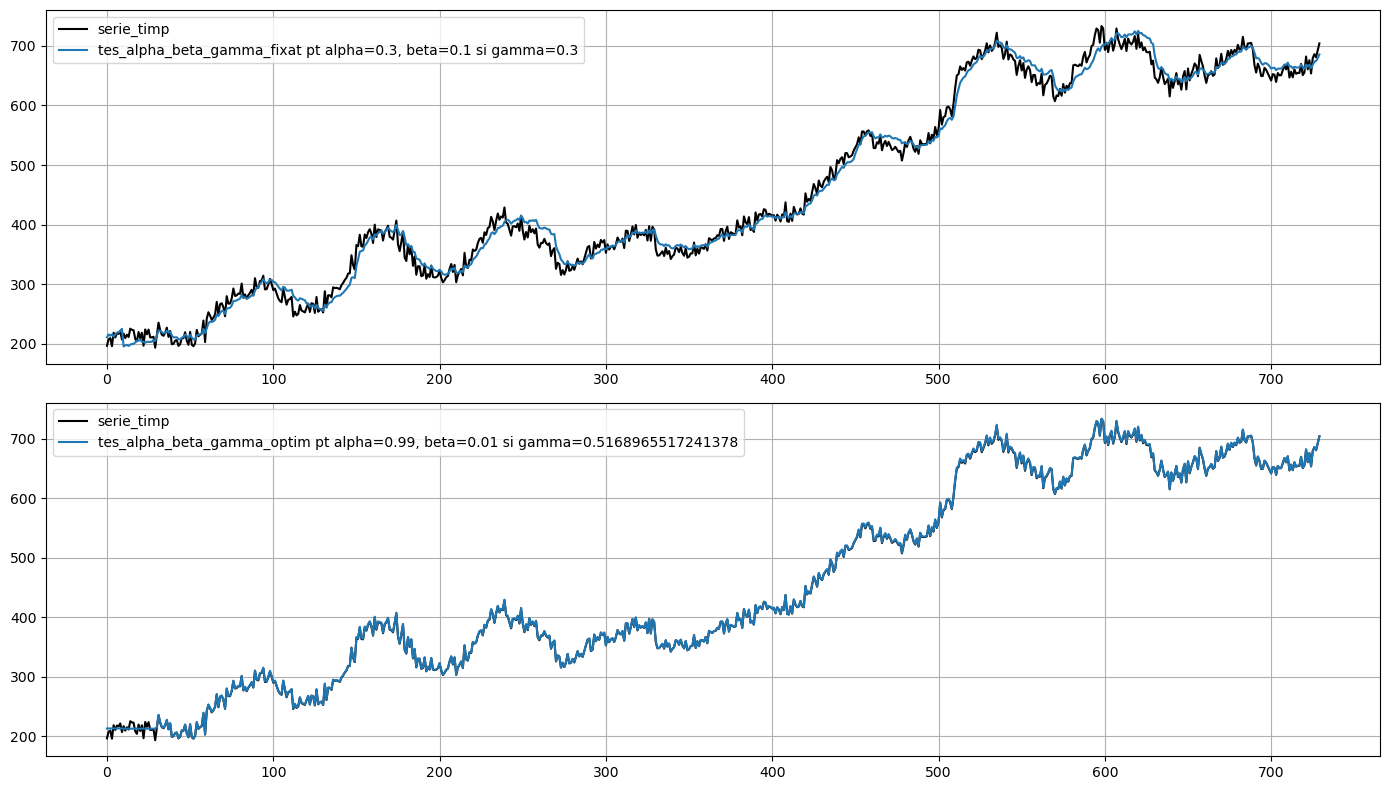

In [43]:
tes_alpha_beta_gamma_optim = calculeaza_tes(alpha_optim, beta_optim, gamma_optim)

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

axs[0].plot(serie_timp, label='serie_timp', color='black')
axs[0].plot(tes_alpha_beta_gamma_fixat, label=f'tes_alpha_beta_gamma_fixat pt alpha={alpha_fixat}, beta={beta_fixat} si gamma={gamma_fixat}')
axs[0].legend()
axs[0].grid(True)
axs[1].plot(serie_timp, label='serie_timp', color='black')
axs[1].plot(tes_alpha_beta_gamma_optim, label=f'tes_alpha_beta_gamma_optim pt alpha={alpha_optim}, beta={beta_optim} si gamma={gamma_optim}')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.savefig(f"lab9_plots/ex2/triple_exponential_smoothing.pdf", format="pdf")
plt.show()

Ex3

theta random (suma=1.00): [0.2598909  0.25698702 0.22592826 0.18599518 0.02437517 0.04682349]
mse moving average: 6672.853958795425


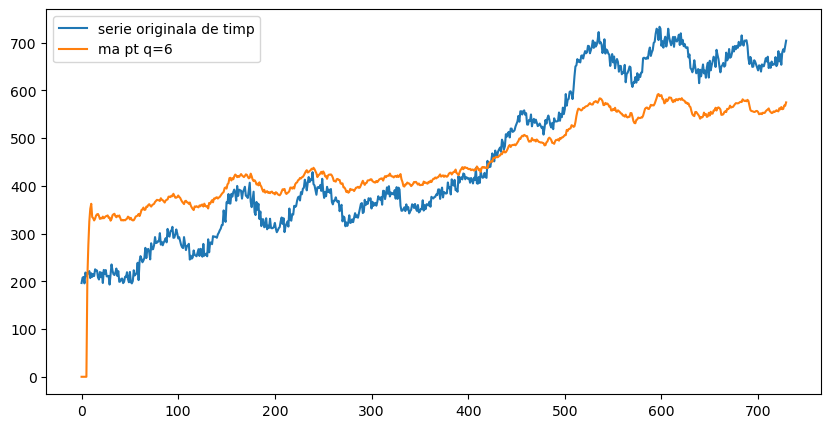

In [70]:
# moving average presupune ca valoarea prezisa la un moment i este o combinatie liniara a erorilor din q pasi anteriori
os.makedirs("./lab9_plots/ex3", exist_ok=True)

q = 6 # orizontul ma

raw_theta = np.random.rand(q) # valori random intre 0 si 1
theta = raw_theta / np.sum(raw_theta) # normalizare pt a avea suma egala cu 1 (in general mai mica)
print(f"theta random (suma={np.sum(theta):.2f}):", theta)

y_mean = np.mean(serie_timp) # medie serie
epsilon = np.zeros(len(serie_timp)) # erori
for i in range(q):
    epsilon[i] = serie_timp[i] - y_mean # diferenta fata de medie pentru primii q pasi
# print(f"epsilon: {epsilon}")

ma_pred = np.zeros(len(serie_timp))
for i in range(q, len(serie_timp)):
    ma_pred[i] = y_mean + np.sum(theta * epsilon[i-q:i][::-1]) # predictia la pasul i este media plus suma ponderata a erorilor din ultimii q pasi
    epsilon[i] = serie_timp[i] - ma_pred[i] # actualizare eroare la pasul i
# print(f"ma_pred: {ma_pred}")
# print(f"epsilon: {epsilon}")

mse = np.mean((serie_timp[q:]-ma_pred[q:])**2)
print(f"mse moving average: {mse}")
plt.figure(figsize=(10,5))
plt.plot(serie_timp, label='serie originala de timp')
plt.plot(ma_pred, label=f'ma pt q={q}')
plt.legend()
plt.savefig(f"lab9_plots/ex3/ma_orizont_fixat.pdf", format="pdf")
plt.show()

Ex4

c:\Users\alice\anaconda3\envs\test_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alice\anaconda3\envs\test_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alice\anaconda3\envs\test_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\alice\anaconda3\envs\test_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\

p_optim=4, q_optim=5 cu mse=193.61


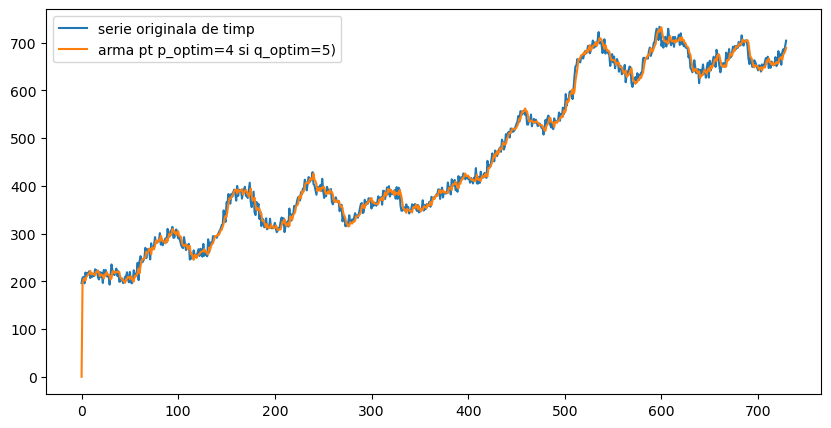

In [ ]:
# model arma unde p = orizont autoregresiv, q = orizont pt moving average
os.makedirs("./lab9_plots/ex4", exist_ok=True)

# cautam param p si q in functie de minimizarea valorilor mse
max_p, max_q = 5, 5
min_mse = float('inf')
p_optim, q_optim, d_optim = 0, 0, 0
model_optim = None

mean = np.mean(serie_timp)
for d in range(0, 3): # diferentieri
    for p in range(1, max_p+1):
        for q in range(1, max_q+1):
            model = ARIMA(serie_timp, order=(p, d, q))
            model_fit = model.fit()
            mse = np.mean((serie_timp-model_fit.fittedvalues)**2)
            if mse < min_mse:
                min_mse = mse
                p_optim, d_optim, q_optim = p, d, q
                model_optim = model_fit

print(f"p_optim={p_optim}, q_optim={q_optim} cu mse={min_mse:.2f}")

arma_pred = model_optim.fittedvalues
plt.figure(figsize=(10,5))
plt.plot(serie_timp, label='serie originala de timp')
plt.plot(arma_pred, label=f'arma pt p_optim={p_optim} si q_optim={q_optim})')
plt.legend()
plt.savefig(f"lab9_plots/ex4/arma_optim.pdf", format="pdf")
plt.show()